## Implementation of Quantum Boltzmann Machine

In [1]:
# !pip install dit

In [2]:
## imports ~~
import numpy as np
# import dit
import matplotlib
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
import math as mt
from qiskit.quantum_info import Pauli
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from scipy.stats import binom

matplotlib.rcParams["figure.dpi"] = 300  # highres display
from IPython.display import clear_output
from time import sleep

## StringHandling


In [3]:
## string to vector conversion 
def string_to_vec(binary_string_input):
    '''
    to_return=np.zeros((1,2**(len(binary_string_input))))
    replace_with_one_at=int(binary_string_input,2)
    to_return[0,replace_with_one_at]=1
    '''
    from qiskit.quantum_info import Statevector #string to vector conversion
    to_return=Statevector.from_label(binary_string_input)
    to_return=np.real(to_return)
    #shape of matrix returned= (value,1)
    to_return=np.reshape(to_return,(len(to_return),1))
    return to_return
def vec_to_string(vector_input,dimn_input_tuple):
    '''
    input vector's shape= (num_rows,1)
    '''
    from qiskit.quantum_info import Statevector
    qiskit_statevec=Statevector(vector_input,dims=dimn_input_tuple)
    dict_statevec=list(qiskit_statevec.to_dict().keys())
    string_to_return= dict_statevec[0]
    return string_to_return

## SamplingSubroutines

In [4]:
# sampling subroutines
def prob_distn_of_bitstring_from_model(eigenvector_mat,eigen_vals):
    num_of_qubits=np.log2(len(eigen_vals))
    #print(num_of_qubits)
    
    partn_fn=0; prob_eigenvec=[]
    for i in range(0,len(eigen_vals)):
        exp_val=np.exp(-eigen_vals[i])
        partn_fn+=exp_val
        prob_eigenvec.append(exp_val)#probs are unnormalised till here
    prob_eigenvec=[i/partn_fn for i in prob_eigenvec]
    #print(prob_eigenvec)
    
    
    num_bits_in_string=int(2**(num_of_qubits))
    #print(num_bits_in_string)
    sq_all_elements_eigenvecs=np.square(eigenvector_mat)
    prob_distn_dict={}
    num_eigenvecs=np.shape(eigenvector_mat)[1]
    #print(num_eigenvecs)
    for i in range(0,num_bits_in_string):
        sum_temp=0
        for j in range(0,num_eigenvecs):
            #print((i,j))
            sum_temp+=sq_all_elements_eigenvecs[i,j]*(prob_eigenvec[j])
        string="0"+str(int(num_of_qubits))+"b"
        prob_distn_dict[format(int(i),string)]=sum_temp
    return prob_distn_dict


In [5]:
def generateSamples(num_qubit, numSamples,p):
    '''
    reference: Manuel bhaiya
    '''
    allSamples = []
    for i in range(1):
        data_binom = binom.rvs(n=2**(num_qubit)-1,p=p,loc=0,size=numSamples) #  16 if we use 4 qubits 
        x = []
        for i in data_binom:
            string="0"+str(int(num_qubit))+"b"
            x.append(format(int(i),string))
            #x.append('{0:04b}'.format(i))                       # 6 must be changed to a 4 if the use 4 qubits 
    return x

In [6]:
#############################################################
params = [] 


## OperatorSubroutines

In [7]:
def matrix_tensor_prod_of_operators(string_tensor_prod):
    from qiskit.quantum_info.operators import Pauli
    tensor_prod=Pauli(string_tensor_prod).to_matrix()
    return tensor_prod

#example
print(matrix_tensor_prod_of_operators('ZI'))
print("_"*10)
print(matrix_tensor_prod_of_operators('IZ'))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
__________
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [8]:
def required_operators(num_qubits,params):
    op_list=[]
    nc2=int(num_qubits*(num_qubits-1))/2
    index=list(range(int(2*num_qubits+nc2)))
    
    #first n: X operators
    #redundant. We won't use this set of operators as h_x's are hyperparas in our model
    for i in range(num_qubits):
        a=["I"]*num_qubits
        a[i]="X"
        to_append="".join(a)
        op_list.append(to_append)
    
    #next n: Z operators
    for i in range(num_qubits):
        a=["I"]*num_qubits
        a[i]="Z"
        to_append="".join(a)
        op_list.append(to_append)
    
    #next nC2: ZiZj operators
    for i in range(0,num_qubits-1):
        a=["I"]*num_qubits
        a[i]="Z"
        for j in range(i+1,num_qubits):
            a[j]="Z"
            to_append="".join(a)
            op_list.append(to_append)
            a[j]="I"
    
    to_return_dict={}
    for i in range(len(op_list)):
        to_return_dict[i]=op_list[i]
    return to_return_dict

def expectation_of_operator(operator_matrix,dict_bitstring_and_prob):
    '''
    Info: This function evaluates expectations like 
         <si_z sj_z>_D, <si_z sj_z>_model
         <si_z sj_z>_D, <si_z sj_z>_model
         (Reference: Manuel bhaiya's thesis pg. 28 eqn no 3.13)
         that are required in gradient descent algorithm
    '''
    
    #inner product
    string_list=list(dict_bitstring_and_prob.keys())
    inner_product_list=[]
    for i in range(len(dict_bitstring_and_prob)):
        vector_of_str=string_to_vec(string_list[i])
        #print(vector_of_str)
        #print("_"*10)
        #print(np.dot(operator_matrix,vector_of_str))
        to_append=np.dot( vector_of_str.T,
                         np.dot(operator_matrix,vector_of_str)
                        )# evaluating <bitstring|Operator|bitstring>
        inner_product_list.append(np.real(to_append)[0][0])
    
    #print("_"*20)
    #print(inner_product_list)

    #calculating <operator>_{some prob distn}= Sumoverj( Prob(j'th bitstring) X <bitstring_j|Operator|bitstring_j> )
    sum_val=0
    for i in range(len(inner_product_list)):
        prob=dict_bitstring_and_prob[ list(dict_bitstring_and_prob.keys())[i] ]
        #print("prob:",prob/sum(list(dict_bitstring_and_prob.values())))
        sum_val+=prob*inner_product_list[i]
        
    return sum_val


### Using BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm for training the given model

reference: https://machinelearningmastery.com/bfgs-optimization-in-python/

In [9]:
# from scipy.optimize import minimize
# from numpy.random import rand

# #objective function #cross relative shannon entropy (log likelihood)
# def objective():
#     pass

# #partial derivatives of the objective function (gradient i believe)
# def derivatives():#this is where quantum expectation values would go!
#     pass

# #define range for the input
# rmin,rmax=1,2#some values

# #define the starting point as a random sample point from the domain
# pt = rmin + rand(2) * (rmax - rmin)#would be different in our case

# #perform the bfgs algorithm
# result_bfgs=minimize(objective,pt,method='BFGS',jac=derivatives)

# #summarise the result
# print('Status : %s' % result_bfgs['message'])
# print('Total Evaluations: %d' % result_bfgs['nfev'])


## UpdationSubroutine

In [10]:
## update 
def update_params(num_qubits, para, dict_rqd_operators, dict_prob_distn_model, dict_prob_distn_data, learning_rate=0.01, verbose= False):
    
    for i in range(num_qubits,len(para)):
        operator_mat = matrix_tensor_prod_of_operators(dict_rqd_operators[i])#getting  required operator matrix
        expectn_op_model = expectation_of_operator(operator_mat,dict_prob_distn_model)

        expectn_op_data = expectation_of_operator(operator_mat,dict_prob_distn_data)
        update_by = expectn_op_data - expectn_op_model
        if(verbose== True):
            print("update by ",i)
            print(update_by)
            print("operator Right Now:",dict_rqd_operators[i])
            print("expectation value of operator model:",expectn_op_model)
        para[i] = para[i]+learning_rate*update_by
    
    return para    

In [11]:
def evals_evec(N,params):
    '''
    Info: function to create hamiltonian  hence evaluate its evals 
    evecs
    '''
    ## initiate parameters
    basis=spin_basis_1d(N,pauli=True) 
    h_x=[[-params[i],i] for i in range(0,N)]
    h_z=[[-params[i],i-N] for i in range(N,2*N)]
    J = params[2*N:]
    J_zz=[]
    counter = 0
    for i in range(0,N-1):
        for j in range(i+1,N):
            J_zz.append([-J[counter],i,j])
            counter += 1

    #########################################################################
    #static and dynamic list
    static=[['zz',J_zz],["x",h_x],["z",h_z]]
    dynamic=[]
    #reference: manuel bhaiya
    no_checks={"check_herm":False,"check_pcon":False,"check_symm":False}
    #defining qbm hamiltonian
    Hamiltonian_qbm=hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    #print(Hamiltonian_qbm)
    #finding eigenvalues and eigen-vector
    E,V=Hamiltonian_qbm.eigh()

    return E, V


In [12]:
from numpy.random import randint,rand
a=rand(2)
print(a)
print(a*10)
print(-5+a*(10))

[0.21918434 0.22432989]
[2.1918434  2.24329894]
[-2.8081566  -2.75670106]


# K.L. divergence

In [13]:
def kl_divergence(dict_prob_distn_data,dict_prob_distn_model):
    list_prob_model=list(dict_prob_distn_data.values())
    list_prob_data=list(dict_prob_distn_model.values())
    
    to_return=0
    for i in range(0,len(list_prob_model)):
        if(list_prob_data[i]== 0):
            to_return+= 0
        if(list_prob_model[i]!= 0):
            to_return+=list_prob_data[i]*np.log(list_prob_model[i]/list_prob_data[i])
    to_return=(-1)*to_return
    
    return to_return
def plot_paramaeter_trajectory(param_list):
    dim = len(param_list[0])
    fig, ax = plt.subplots(1, dim)
    pass
    
    
    

## QBM.Subroutine

In [65]:
def run(N, params, trainingDict, iterations, learning_rate= 0.0001,savefigs= False,step=50,figkey= None,verbose= False, progressbar_params= False, progressbar_dist= False,skip_steps= 100):
    ###############################################################################
    #define training metrics
    operators= required_operators(N, params)
    #print("operators are:")
    #print(operators)
    kldiv_list= []
    param_list= []
    model_dist_dict_list= []
    fig_i = 0
    for iter in range(iterations):
        E,V= evals_evec(N,params)#E: eigen values,V: matrix of eigen vectors
        #eigen vectors are arranged columnwise~
        #########################################################################
        #generate model dist
        model_dist_dict = prob_distn_of_bitstring_from_model(V,E)
        kldiv_list.append(kl_divergence(trainingDict, model_dist_dict))
        model_dist_dict_list.append(model_dist_dict)
        

        #updating parmaters iteratively
        # print("going inside update params function")
        params = update_params(N, params, operators,
                             model_dist_dict, trainingDict, 
                             learning_rate= learning_rate, verbose= verbose)
        param_list.append(params)

        ########################################################################
        ## savefigs
        
        if(savefigs==True):
            if(iter%skip_steps == 0):    
                fig_i += 1
                plot_histogram([trainingDict, model_dist_dict], figsize=(12,8),filename= figkey+'figstep_'+str(fig_i)+'.png',bar_labels=True,legend=["Data", "Model"],title="TrainingProgress | Iterations: "+str(iter)+" | eta: "+str(eta))
        

        ########################################################################
        ##broadcast update
        if(iter%skip_steps== 0):
            if(progressbar_params== True):
                print("params: ")
                print( params,  end='\n')
            if(progressbar_dist== True):
                # print("dist: ")
                # print(model_dist_dict, end='\n')
                plt.figure(figsize=(10,10))
                clear_output(wait=True)
                plot_histogram(model_dist_dict)
                plt.show()
                sleep(0.01)
            
        
    return param_list, kldiv_list, model_dist_dict, 

In [40]:
51%50

1

## Trials


## generate data distribution

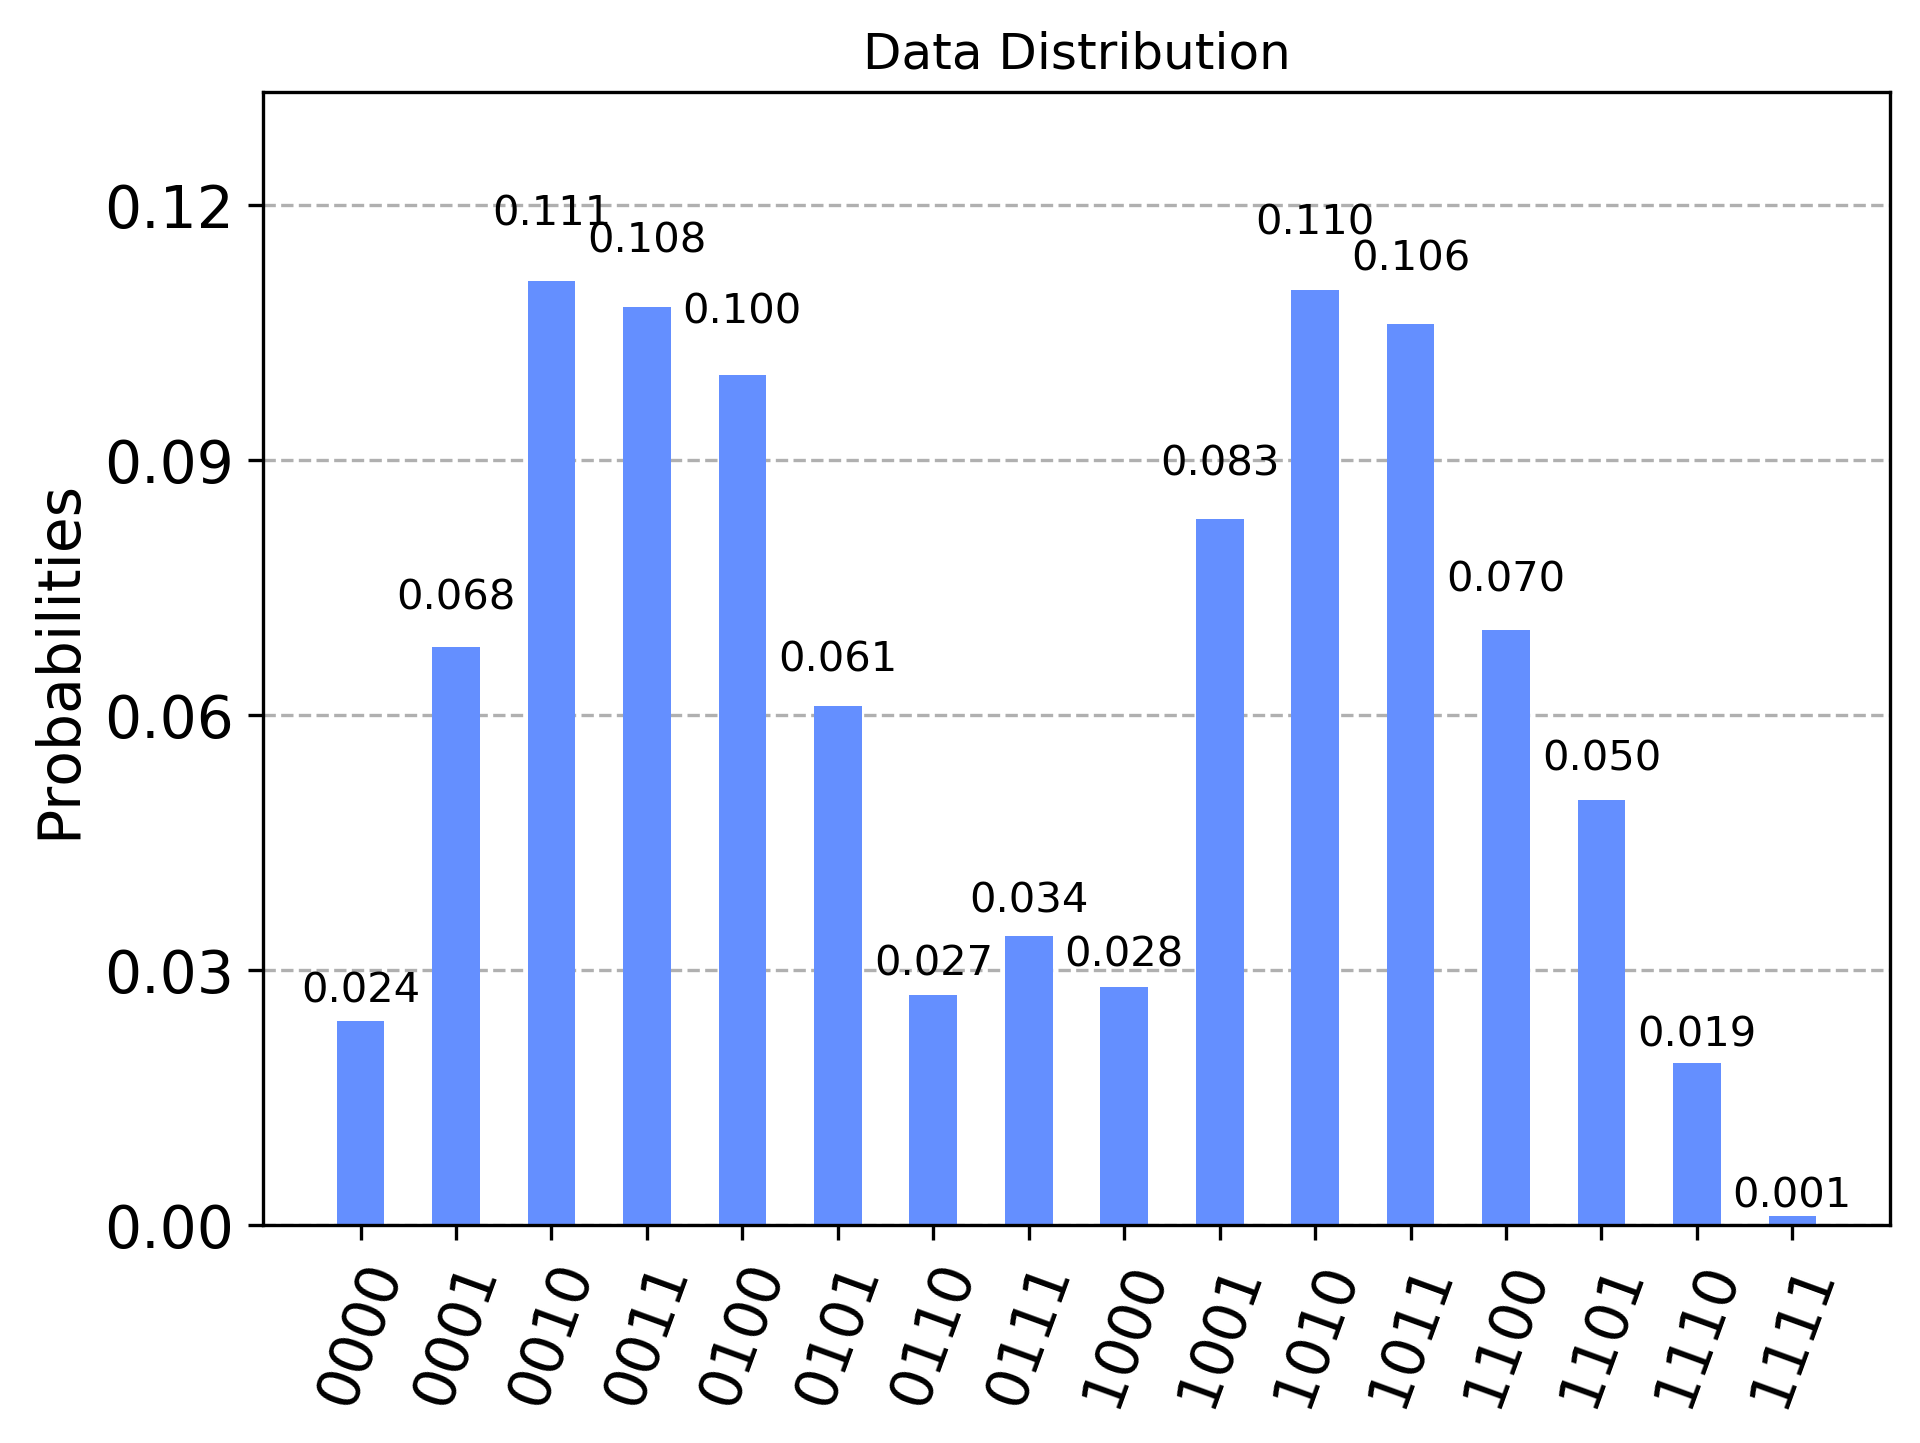

In [15]:
#########################################################################
N=4 # number of qubits
numParams = int(2*N + N*(N-1)/2)
## reference: Manuel bhaiya
ts = generateSamples(N,500,0.7)             ## this one is on the left of the tomo
temp = np.unique(ts,return_counts=True)
TS = {temp[0][i]:temp[1][i] for i in range(len(temp[0]))}
ps = generateSamples(N,500,0.2)             ## this on is in the middle of the tomo
pemp = np.unique(ps,return_counts=True)
PS = {pemp[0][i]:pemp[1][i] for i in range(len(pemp[0]))}
gs = generateSamples(N,500,0.8)             ## this on is in the middle of the tomo
gemp = np.unique(ps,return_counts=True)
GS = {pemp[0][i]:pemp[1][i] for i in range(len(pemp[0]))}

both = list((np.append(ts,ps)))          ## this one has both
stemp = np.unique(both,return_counts=True)
trainingDict = {stemp[0][i]:stemp[1][i] for i in range(len(stemp[0]))} 
plot_histogram(trainingDict,title='Data Distribution')



In [16]:
# ##
# temp = np.unique(np.random.choice(['00','01','10','11'], size = 1000), return_counts= True)
# trainingDict_2 = {temp[0][i]:temp[1][i] for i in range(len(temp[0]))}
# plot_histogram(trainingDict_2)

# run Quantum Boltzmann Machine

initial parameters: 
[10.3, 10.3, 10.3, 10.3, 0.09945949769090401, -0.14635938750429678, -0.21126273948591523, -0.36446070635434435, -0.015565846438899023, -0.013076444759032912, 0.22934572420075994, -0.4675355159790231, -0.03499254261919971, 0.29354235891150704]
final paramters: 
[10.3, 10.3, 10.3, 10.3, 0.7591368521202798, 2.6122953229906485, -0.5304954048092801, -0.5838699987584752, -0.9953886295904841, -0.23304387466722856, 0.26922895773518585, -4.78620324038726, -1.6545064614040232, -0.2866031140821233]


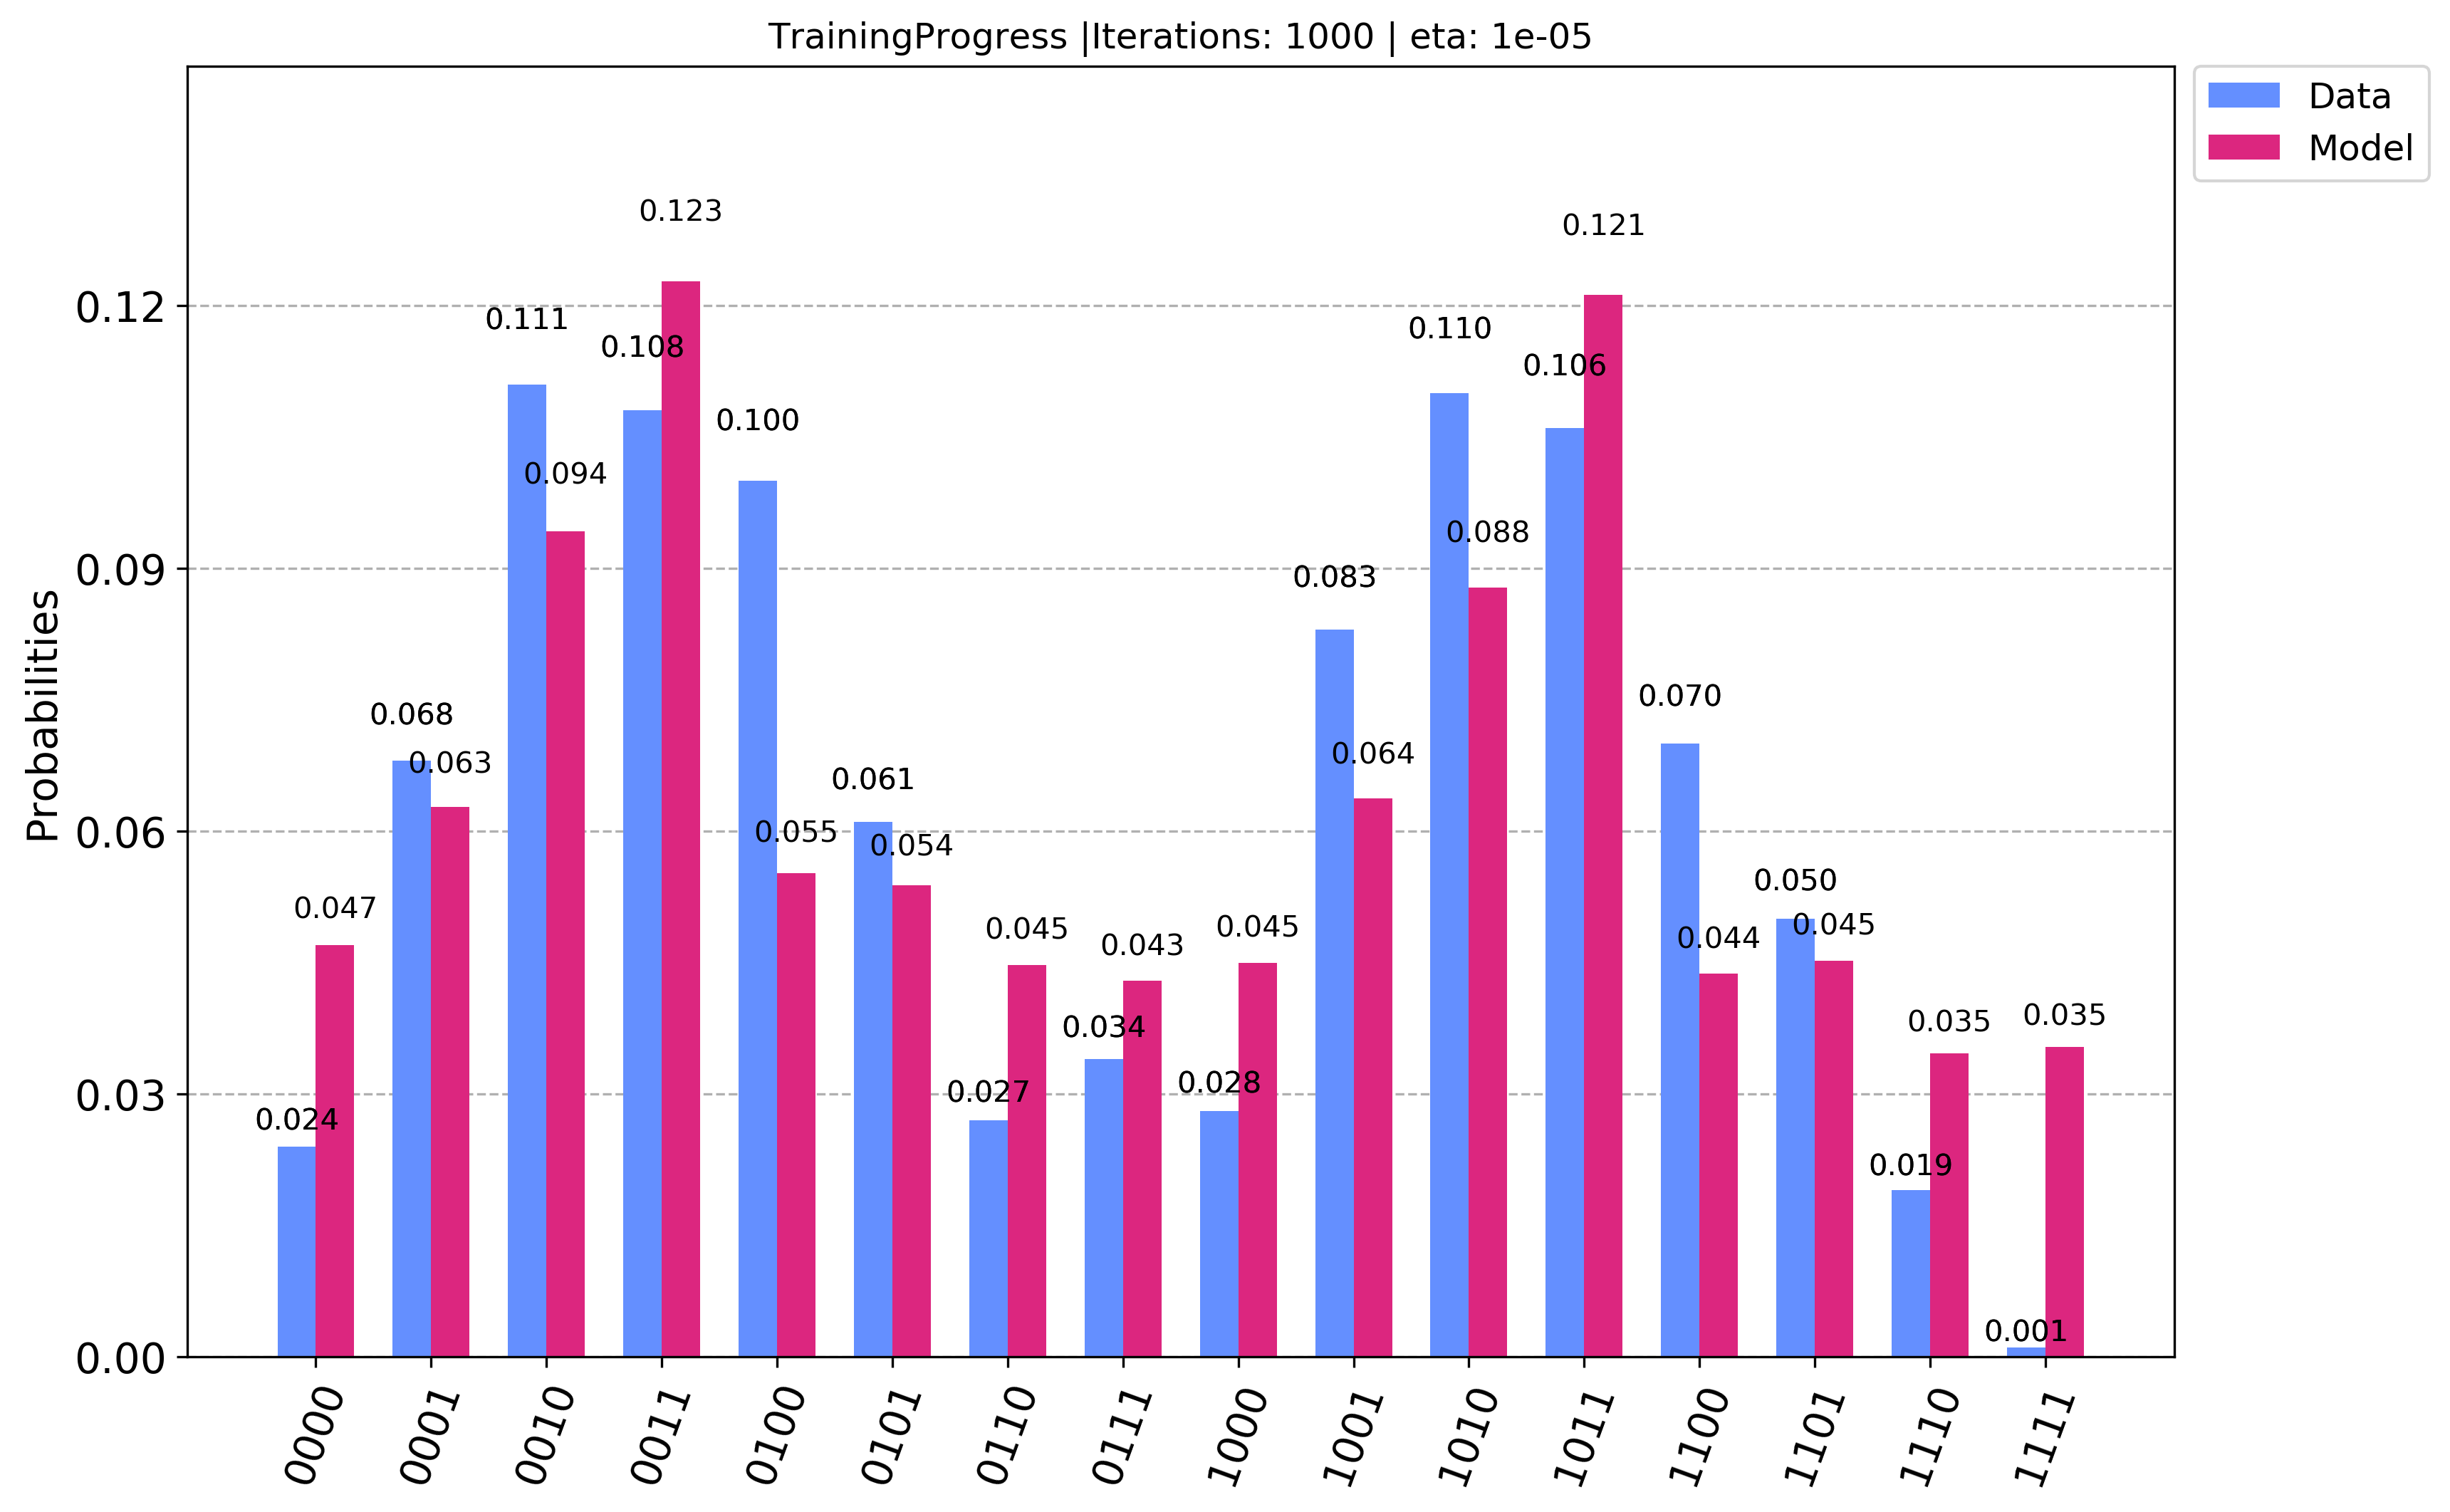

In [67]:
#########################################################################
## define model parameters
N=4# number of qubits
numParams = int(2*N + N*(N-1)/2)

J=1.0
g=0.809 # transverse field
h=0.9045 # longitudinal field
basis=spin_basis_1d(N,pauli=True)
# for the time being we're interested in diagonal hamiltonian
params= [10.3]*N + list(np.random.rand(numParams-N)-0.5) #[first N hx| next n:hz | next nC2: h1zh2z]
# params = [0,0,0,0,0]
iterations = 1000
eta = 0.00001
print("initial parameters: ");print(params)
# model_dist_0 = run(N, params, trainingDict,
#                         1, learning_rate=0.00001,progressbar_dist= False,progressbar_params=False,
#                         verbose= False)[2]

p, kl, model_dist = run(N, params, trainingDict,
                        iterations, learning_rate=eta,skip_steps=50,savefigs=True,figkey='wt_hx_' ,progressbar_dist= False,progressbar_params=False,
                        verbose= False)
print("final paramters: ");print(p[-1])
plot_histogram([trainingDict, model_dist], figsize=(12,8),bar_labels=True,legend=["Data", "Model"],title="TrainingProgress |Iterations: "+str(iterations)+" | eta: "+str(eta))



initial parameters: 
[0.5, 0.5, 0.5, 0.5, -0.4823229615352972, 0.22581633302357396, 0.4526708381264257, -0.16738403454835427, 0.2784494223009524, -0.08967269715126103, 0.25955663836954723, -0.3529054536752039, -0.19865314606056073, 0.14368955464962418]
final paramters: 
[0.5, 0.5, 0.5, 0.5, 0.5799190906352001, 4.628372155798779, -0.0471137375156647, -0.5071554620251463, -1.284331371788507, -0.44634059715046936, 0.31763156195825915, -7.25066222937547, -2.778078754533093, -0.7960944781719316]


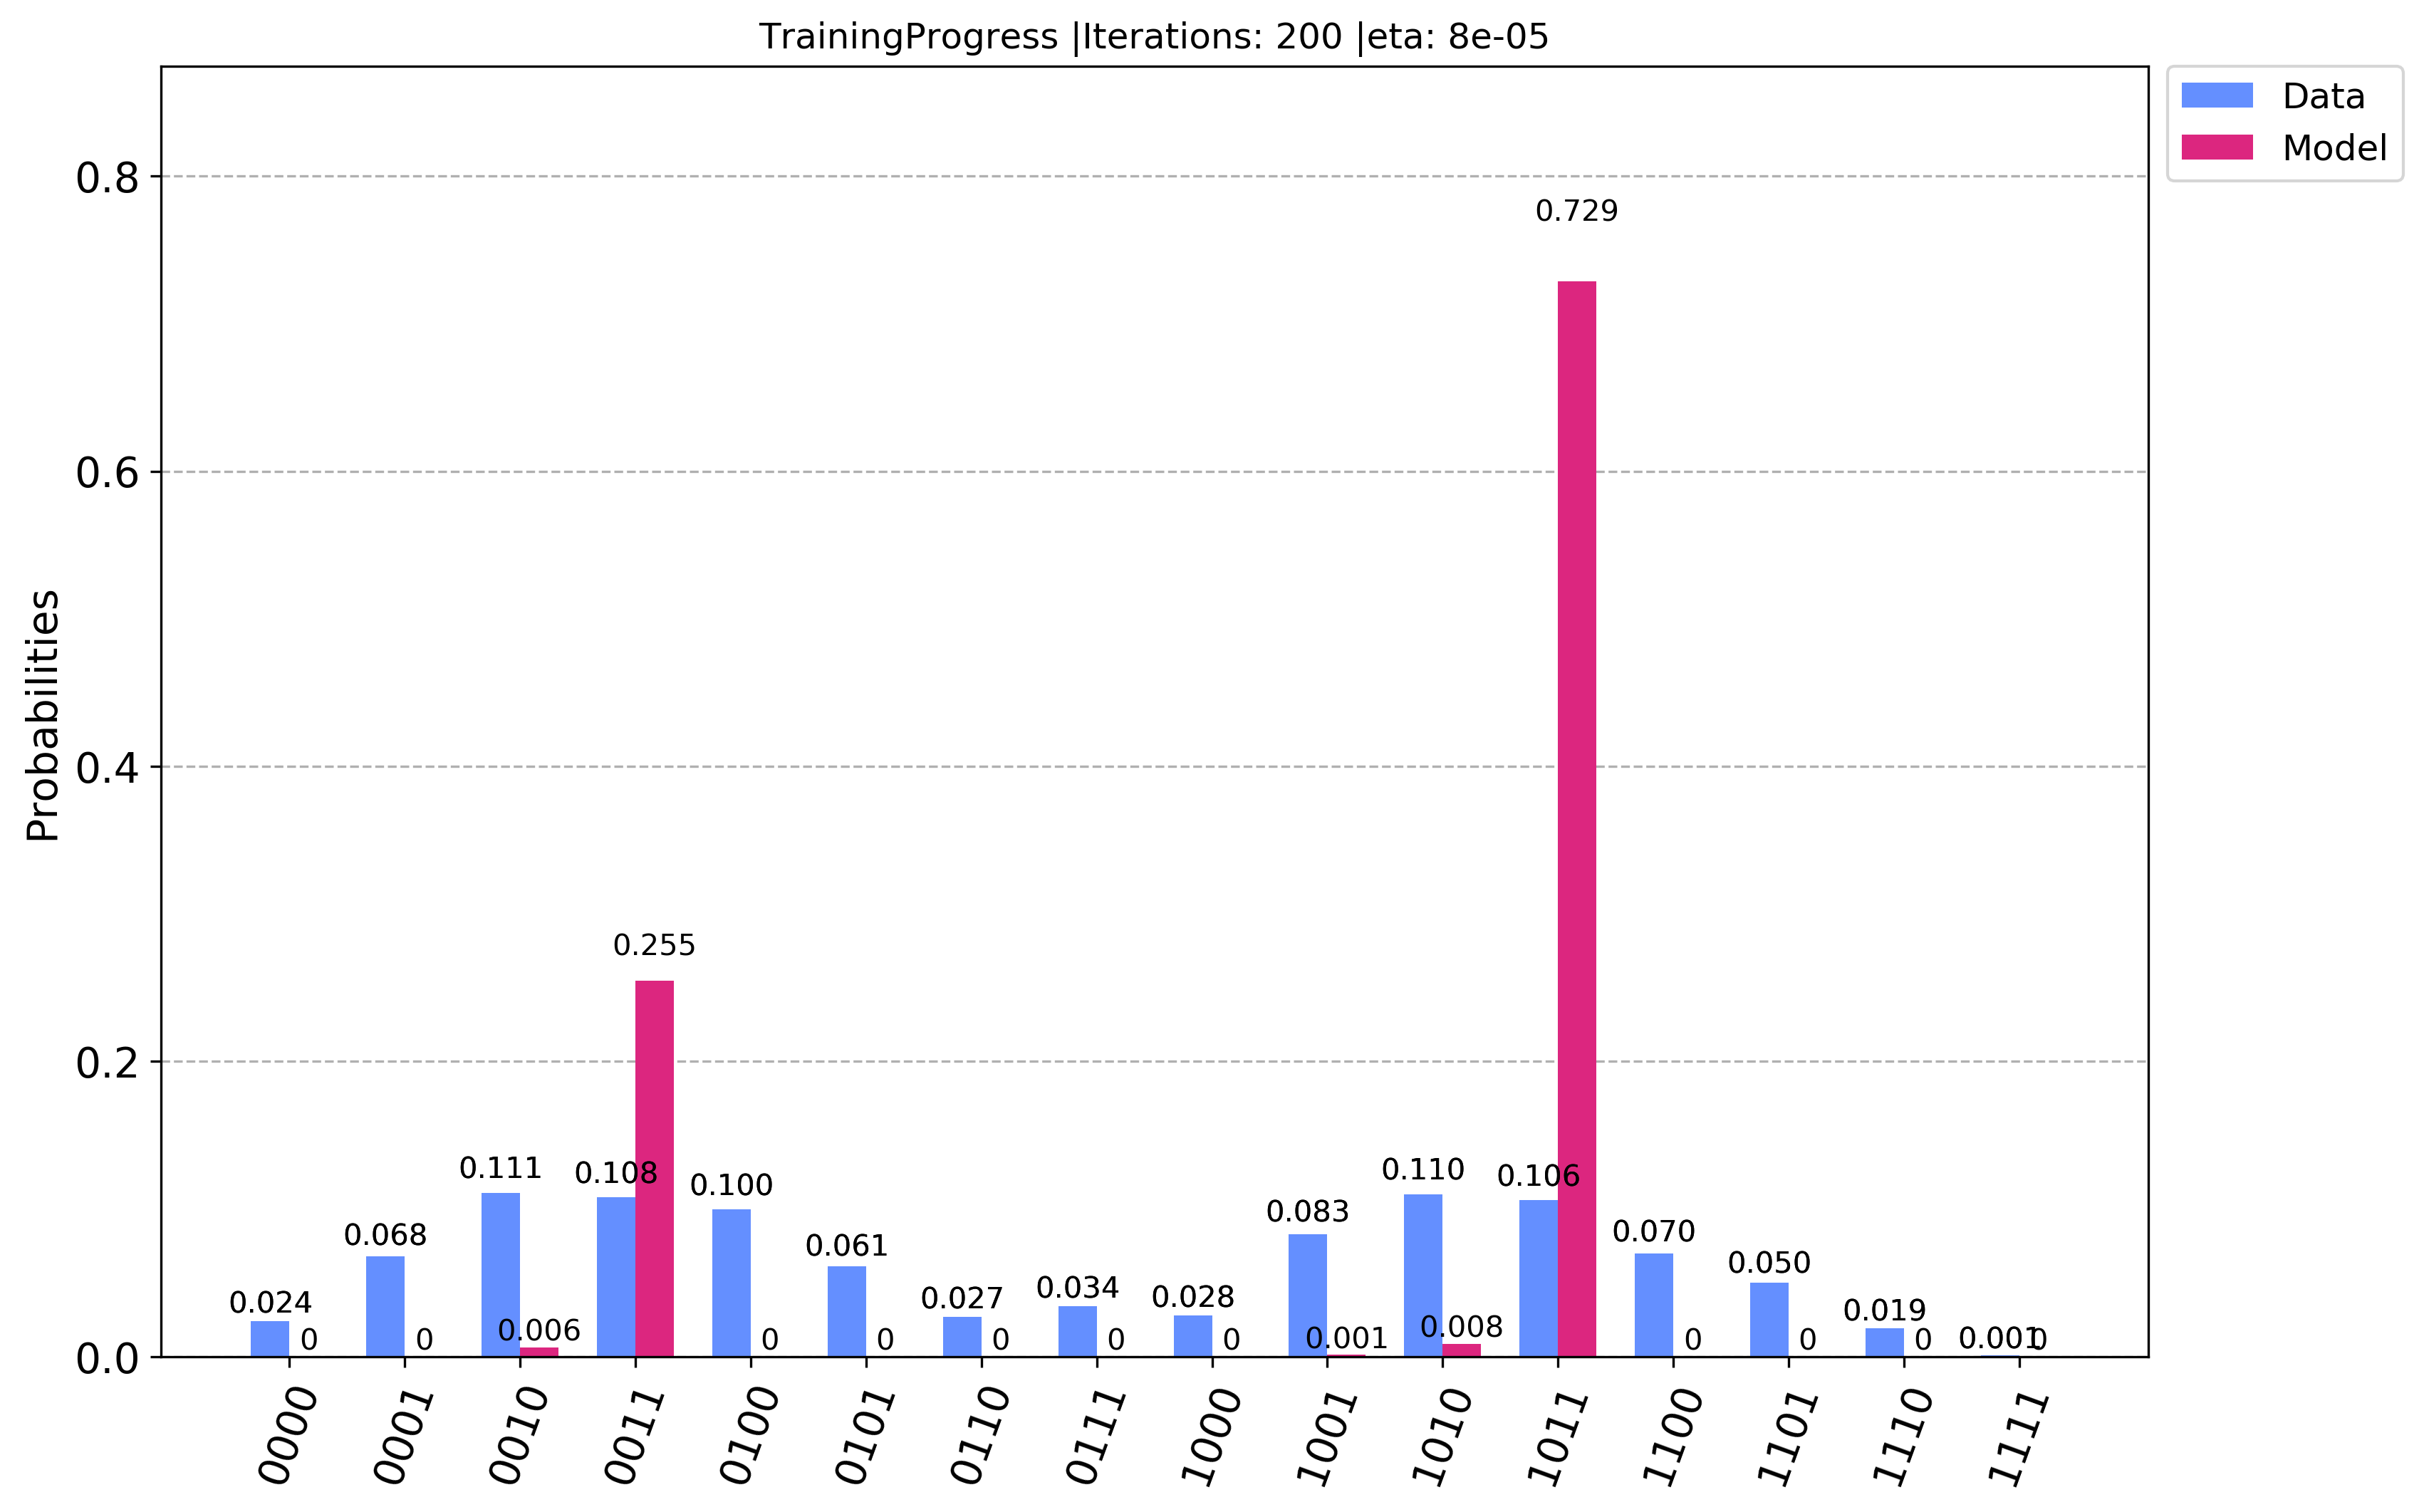

In [70]:
#########################################################################
## define model parameters
N=4# number of qubits
numParams = int(2*N + N*(N-1)/2)

J=1.0
g=0.809 # transverse field
h=0.9045 # longitudinal field
basis=spin_basis_1d(N,pauli=True)
# for the time being we're interested in diagonal hamiltonian
params= [0.5]*N + list(np.random.rand(numParams-N)-0.5) #[first N hx| next n:hz | next nC2: h1zh2z]
# params = [0,0,0,0,0]
iterations = 200
eta = 0.00008
print("initial parameters: ");print(params)
# model_dist_0 = run(N, params, trainingDict,
#                         1, learning_rate=0.00001,progressbar_dist= False,progressbar_params=False,
#                         verbose= False)[2]

p, kl, model_dist = run(N, params, trainingDict,
                        iterations, learning_rate=eta,skip_steps=10,savefigs=True,figkey='wot_hx_' ,progressbar_dist= False,progressbar_params=False,
                        verbose= False)
print("final paramters: ");print(p[-1])
plot_histogram([trainingDict, model_dist], figsize=(12,8),bar_labels=True,legend=["Data", "Model"],title="TrainingProgress |Iterations: "+str(iterations)+" |eta: "+str(eta))



## Calibration Experiments

1. kl

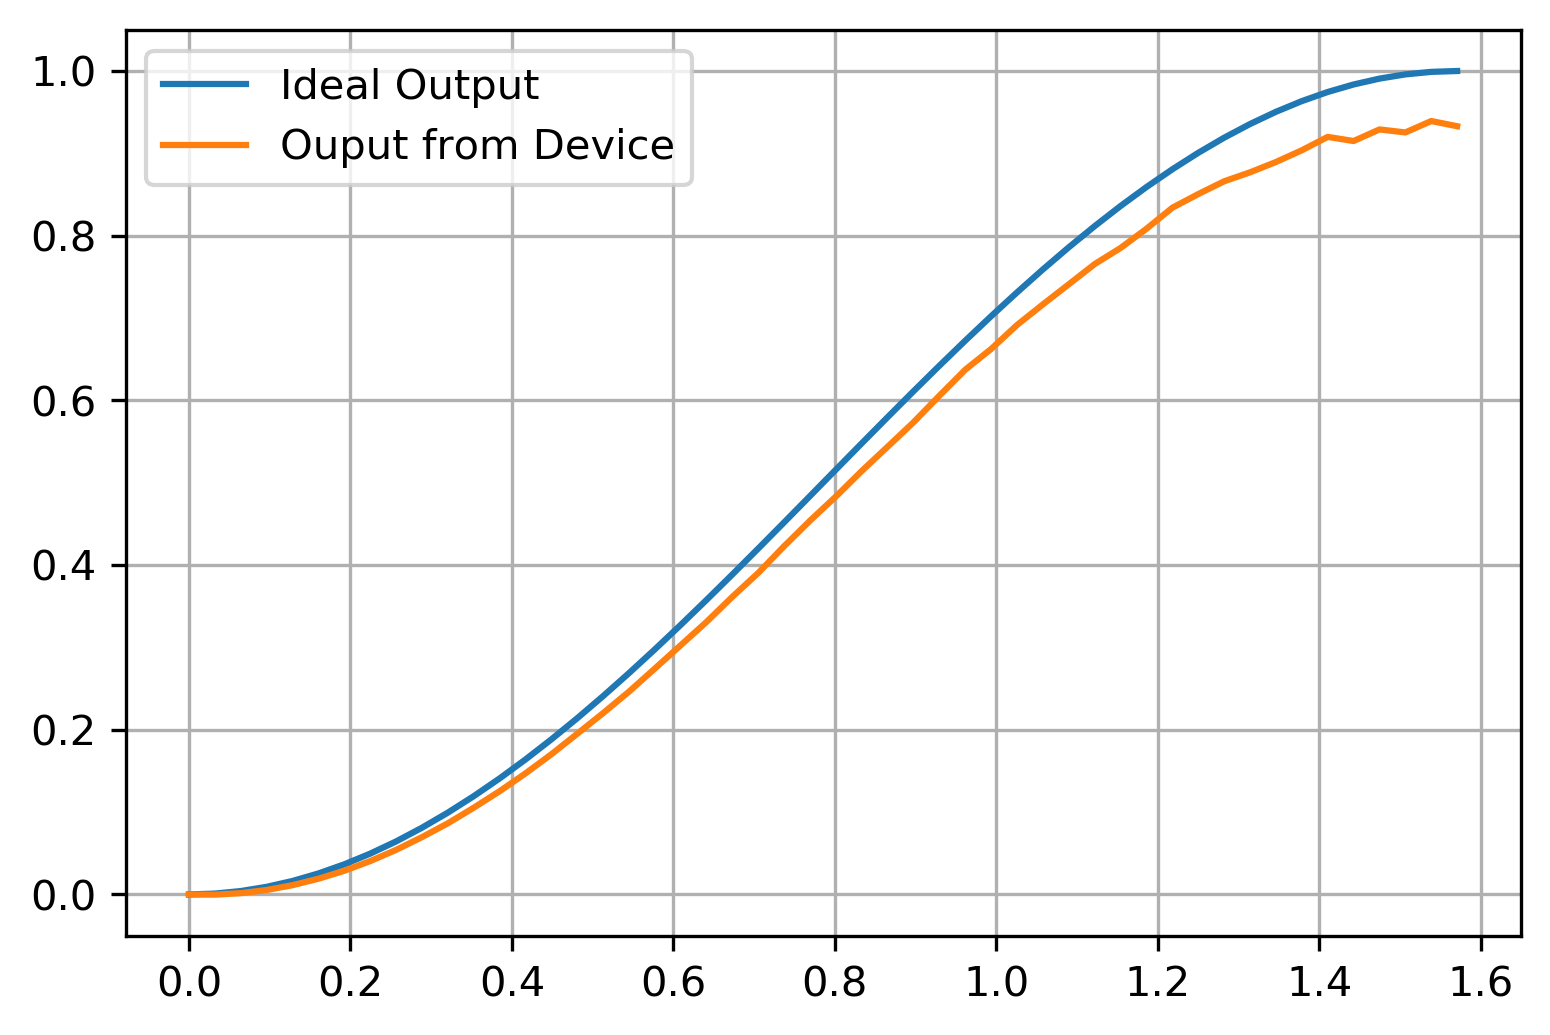

In [20]:
from math import pi
dp = 50
x= np.linspace(0, pi/2, dp)
y= np.zeros(dp)
def sin2(x):
    return np.sin(x)*np.sin(x)
def sin2e(x):
    return sin2(x)- 0.001*x**2*np.random.normal(0.7*x**2,2) - 0.04*x
y = sin2(x)
ye = sin2e(x)
plt.plot(x,y, label= 'Ideal Output')
plt.plot(x,ye, label='Ouput from Device')
plt.legend()
plt.grid()
plt.show()